![header](../figures/logos_partenaires_DC_WOC-ESA.jpg)

# Mediterranean: Benchmark BFN-QG geostrophic currents maps
 

***
**Authors:** Datlas <br>
**Copyright:** 2023 Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Mediterranean: Benchmark of BFN-QG geostrophic currents maps</center></h1>
 <h5><center> The notebook aims to evaluate the surface current maps produced by the BFN-QG system in the Mediterranean region.</center></h5> 

In [1]:
from glob import glob
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [10]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_switchvar import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [5]:
time_min = '2019-01-15'                                        # time min for analysis
time_max = '2019-12-15'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

# Region details
region = 'Mediterranean'
lon_min = -5                                          # domain min longitude
lon_max = 25                                          # domain max longitude
lat_min = 35.                                          # domain min latitude
lat_max = 47.                                          # domain max latitude

box_lonlat = {'lon_min':lon_min,'lon_max':lon_max,'lat_min':lat_min,'lat_max':lat_max}

method_name = 'BFNQG'

stat_output_filename = f'{output_dir}/stat_uv_'+method_name+'_'+region+'.nc'   # output statistical analysis filename
psd_output_filename = f'{output_dir}/psd_uv_'+method_name+'_'+region+'.nc'     # output spectral analysis filename
segment_lenght = np.timedelta64(40, 'D')                      # spectral parameter: drifters segment lenght in days to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## [Sea Surface currents from Drifters database](https://doi.org/10.17882/86236)

In [6]:
filenames_drifters = sorted(glob('../data/Mediterranean/eval_Mediterranean/indep_drifters_Mediterranean.nc'))

In [7]:
ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='time')
ds_drifter = ds_drifter.where((ds_drifter.time >= np.datetime64(time_min)) & (ds_drifter.time <=  np.datetime64(time_max)), drop=True)
ds_drifter

<xarray.Dataset>
Dimensions:    (time: 11571)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-15 2019-01-15 ... 2019-12-15
    latitude   (time) float32 dask.array<chunksize=(11571,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(11571,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(11571,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(11571,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(11571,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               116275
    date_update:                 2020-10-13T12:17:40Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -58.44
    last_longitude_observation:  82.75
    last_latitude_observation:   -18.49
    date_drog_lost:              2017-01-21T03:37:00Z
    death_type:                  stop transmitting
    last_date_observation:       2019-01-16T01:51:00Z

## Sea Surface current maps to evaluate

In [17]:
%%time
list_of_maps = sorted(glob('/Users/sammymetref/Documents/DATLAS/Notebooks/MASSH/mapping/myexamples/outputs/DC_WOC-Med_BFNQG/DC_WOC-Med_BFNQG_y2019m*'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps = ds_maps.rename({'lon':'longitude','lat':'latitude'})
ds_maps.sla.attrs = {'grid_mapping': 'crs',
                     'long_name': 'Sea level anomaly',
                     'standard_name': 'sea_surface_height_above_sea_level',
                     'units': 'm'}
ds_maps

CPU times: user 3.2 s, sys: 281 ms, total: 3.48 s
Wall time: 3.97 s


<xarray.Dataset>
Dimensions:    (time: 335, latitude: 122, longitude: 301)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-15 2019-01-16 ... 2019-12-15
  * longitude  (longitude) float64 -5.0 -4.9 -4.8 -4.7 ... 24.7 24.8 24.9 25.0
  * latitude   (latitude) float64 35.0 35.1 35.2 35.3 ... 46.8 46.9 47.0 47.1
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 122, 301), meta=np.ndarray>
    pv         (time, latitude, longitude) float64 dask.array<chunksize=(1, 122, 301), meta=np.ndarray>

In [18]:
ds_maps = sla_to_ssh(ds_maps,'/Users/sammymetref/Documents/DATLAS/Data/cnes_obs-sl_glo_phy-mdt_my_0.125deg_P20Y_1695393893725_1mdt.nc')

u,v = ssh_to_currents(ds_maps.ssh, ds_maps.longitude, ds_maps.latitude)

ds_maps = ds_maps.assign(ugos=lambda ds_maps: ds_maps.sla*0  + u)
ds_maps.ugos.attrs = {'grid_mapping': 'crs',
                    'long_name': 'Absolute geostrophic velocity: zonal component',
                    'standard_name': 'surface_geostrophic_eastward_sea_water_velocity',
                    'units': 'm/s'}

ds_maps = ds_maps.assign(vgos=lambda ds_maps: ds_maps.sla*0  + v)
ds_maps.vgos.attrs = {'grid_mapping': 'crs',
                    'long_name': 'Absolute geostrophic velocity: meridian component',
                    'standard_name': 'surface_geostrophic_northward_sea_water_velocity',
                    'units': 'm/s'}

ds_maps.longitude.attrs = {'valid_max': 359.875,
 'valid_min': 0.125,
 'bounds': 'lon_bnds',
 'axis': 'X',
 'long_name': 'Longitude',
 'standard_name': 'longitude',
 'units': 'degrees_east'}

ds_maps.latitude.attrs = {'axis': 'Y',
 'bounds': 'lat_bnds',
 'long_name': 'Latitude',
 'standard_name': 'latitude',
 'units': 'degrees_north',
 'valid_max': 89.875,
 'valid_min': -89.875}

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface currents maps onto drifters positions

In [23]:
ds_interp = run_interpolation_drifters(ds_maps, ds_drifter, time_min, time_max)
ds_interp = ds_interp.dropna('time')
ds_interp = ds_interp.sortby('time')
ds_interp

2024-03-14 09:47:45 INFO     fetch data from 2019-01-15 00:00:00 to 2019-02-01 00:00:00
2024-03-14 09:47:45 INFO     fetch data from 2019-01-15 00:00:00 to 2019-02-01 00:00:00
2024-03-14 09:47:45 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2024-03-14 09:47:45 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2024-03-14 09:47:46 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2024-03-14 09:47:46 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2024-03-14 09:47:46 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2024-03-14 09:47:46 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2024-03-14 09:47:46 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2024-03-14 09:47:47 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2024-03-14 09:47:47 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2024-03-14 09:47:47 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 9017)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-15 ... 2019-12-15
Data variables:
    EWCT               (time) float32 0.07484 0.06264 -0.01256 ... 0.121 0.2608
    NSCT               (time) float32 -0.08611 0.08196 -0.1445 ... 0.3755 0.1713
    sensor_id          (time) float64 6.562e+07 6.631e+07 ... 6.755e+07
    latitude           (time) float32 35.21 43.0 35.18 ... 40.03 38.11 39.9
    longitude          (time) float32 22.34 10.22 22.37 ... 7.041 4.981 2.297
    ugos_interpolated  (time) float64 0.005307 0.006718 ... 0.1056 0.09877
    vgos_interpolated  (time) float64 -0.07356 -0.07668 ... -0.03854 0.08717

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the surface currents maps have been interpolated to the position of the drifters, it is possible to calculate different statistics on the time series of zonal and meridional velocities. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps. 

In [24]:
# Compute gridded stats
compute_stat_scores_uv(ds_interp, stat_output_filename,method_name=method_name)

2024-03-14 09:48:05 INFO     Compute mapping error all scales
2024-03-14 09:48:06 INFO     Compute statistics
2024-03-14 09:48:08 INFO     Stat file saved as: ../results/stat_uv_BFNQG_Mediterranean.nc
2024-03-14 09:48:08 INFO     Compute statistics by oceanic regime


Total RMSE(u)= 0.16000144213710563 m/s
Total RMSE(v)= 0.14809064387217297 m/s
Total RMSE(u) score= 0.3134976674180796
Total RMSE(v) score= 0.2868448065882473


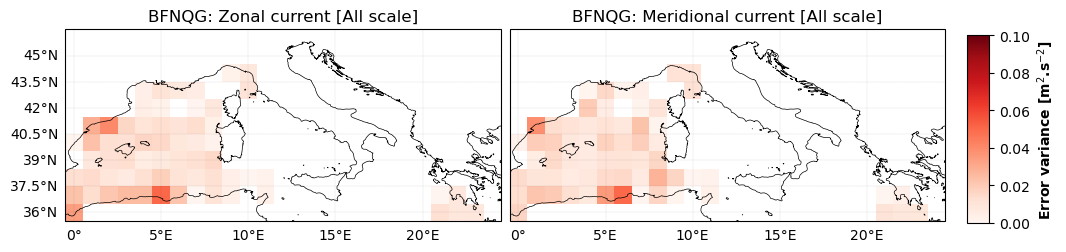

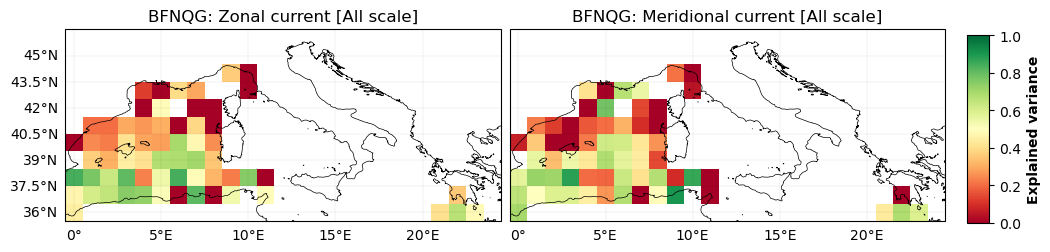

In [26]:
# Plot gridded stats 
plot_stat_score_map_uv_png(stat_output_filename,region=region,box_lonlat=box_lonlat)

The figure shows that the maximum mapping errors are found in intense current systems, for example in the GulfStream, Kuroshio and Agulhas regions. 

However, when considering the full scale of motion in the drifter database, the surface current maps capture up to 80% of the variability of drifter currents in the Western Boundary Currents and Antarctic Circumpolar Currents (ACC). The geostrophic signal dominates the ageostrophic signal in these regions. In regions with low ocean variability, only a few percent of the total drifter current variability is recovered in the maps, which may be associated with a larger ageostrophic signal in these regions.

In [28]:
plot_stat_uv_by_regimes(stat_output_filename)

,mapping_err_u_var [m²/s²],mapping_err_v_var [m²/s²],ugos_interpolated_var [m²/s²],EWCT_var [m²/s²],vgos_interpolated_var [m²/s²],NSCT_var [m²/s²],var_score_u_allscale,var_score_v_allscale
coastal,0.025457,0.021933,0.018591,0.049951,0.01881,0.042992,0.490364,0.489843
offshore_highvar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offshore_lowvar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
equatorial_band,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antarctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
